# Task 

- Take an open source object detection model & implement the calculation of mAP and precision recall curves

# Implementation Details

- Used yolo v3 model from torch hub trained on coco dataset

- Considered "Person" and "Bicycle" classes for the implementation

- Folders :
    - 'test_images' : Folder contains the test images.
    - 'test_images_ground_truth' : Folder contains ground truth annotations in yolo format. (Manually Annotated using LabelImg tool)  
    #

- Implemented a class with methods for :
    - Loadind the object detection model and inference
    - Calculation of mAP@IOU_threshold and plotting Precision-Recall Curves
    - Visualization of Ground Truth & Predictions


In [2]:
from result_utilities import FormatResult,filter_classes,boxes_from_yoloformat,showBoxes,get_iou
from tqdm.autonotebook import tqdm
import os,cv2,glob,torch
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class ODMetric:
    
    def __init__(self,
                 image_folder_path,
                 ground_truth_annotation_path):
        '''
        Args:
            input_image_folder : folder path of test input images.
            ground_truth_annotation_path : folder path for ground truth annotations of test input images.
        '''
        self.all_images = glob.glob(image_folder_path+"/*")
        self.gt_annotations = glob.glob(ground_truth_annotation_path+'/*')
        self.class_maps = {0: 'person', 1: 'bicycle'}
        
        assert len(self.all_images) == len(self.gt_annotations), 'Number of images and annotations must be same'
        
    def load_model(self):
        '''
        A method to load the object detection model
        '''
        self.model = torch.hub.load('ultralytics/yolov3', 'yolov3')
        print('Model Successfully loaded..')
        
    def run_inference(self):
        '''
        A method to run model inference on images in input_image_folder.
        '''
        print(f'Total images : {len(self.all_images)}')
        
        self._predictions = []
        
        for indx,im_path in tqdm(enumerate(self.all_images),total=len(self.all_images)):
            
            with torch.no_grad():
                result = self.model(im_path)
                
            FM = FormatResult(result.xyxy[0])
            cords,conf,clss = FM.return_all_results()
            cords,conf,clss = filter_classes(cords,conf,clss,filter_labels=[0,1]) #only consider person (label = 0) & bicycle class (label= 1)
            
            for cd,cf,cl in zip(cords,conf,clss):
                self._predictions.append([indx,cd,cl,cf,im_path]) # format : [image_index, coordinates (xyxy), class label,confidence,image_path]
        
            del result
            torch.cuda.empty_cache()
            
        print('Inference Completed..')
        return self._predictions
    
    def calculate_mAP(self,
                      iou_threshold=0.5,
                      no_of_classes=2):
        '''
        A method to calculate mAP @ iou_threshold 
        '''
        # Load ground truth annotations -----------------------------------------------------------------------
        self._ground_truths = []
        
        for indx,(im_path,gt_path) in enumerate(zip(self.all_images,self.gt_annotations)):
            
            if os.path.getsize(gt_path) == 0:
                continue
            
            im_name = os.path.splitext(os.path.basename(im_path))[0]
            annotations_name = os.path.splitext(os.path.basename(gt_path))[0]
                       
            assert im_name == annotations_name, 'Image Filename & Annotation File name should be same'
            
            _,bx = boxes_from_yoloformat(im_path,
                                         gt_path,
                                         output_format='xyxy')
            
            for b in bx:
                label = int(b[0])
                box = list(b[1])
                self._ground_truths.append([indx,box,label,im_path]) # [image_index, ground truth bounding box, ground truth label, image_path]
        
        # Calculate per class precision & Recall ---------------------------------------------------------------
        plt.figure(figsize=(10,10))
        averageprecisions = []
           
        for cl in range(no_of_classes):
            
            detections = []
            groundtruths = []
            Precisions,Recalls = None,None
            
            for d in self._predictions:
                if d[2] == cl:
                    detections.append(d)
            
            for g in self._ground_truths:
                if g[2] == cl:
                    groundtruths.append(g)
            
            amt_boxes = Counter([gt[0] for gt in groundtruths]) # {image_indx : number of gt boxes of cl class}
        
            for k,v in amt_boxes.items():
                amt_boxes[k] = np.zeros(v)  # {image_indx : zeros array of shape = number of gt boxes of cl class}
        
            detections.sort(key=lambda p:p[3], reverse=True) #sort by confidence scores / probability scores
      
            TruePostive = np.zeros(len(detections)) 
            FalsePostive = np.zeros(len(detections))
            TotalGTBoxes = len(groundtruths)
            
            for dindx, dect in enumerate(detections):
                gt_image_info = [bbx for bbx in groundtruths if bbx[0] == dect[0]] # get details of a single image.
                iou_best = 0
        
                # iou comparisons between a detected bb & all gt bb 
                for idx,gt in enumerate(gt_image_info):
                    iou = get_iou(dect[1],gt[1]) 
                    if iou > iou_best:
                        iou_best = iou
                        gtindx_best = idx
                
                if iou_best >= iou_threshold:
                    if amt_boxes[dect[0]][gtindx_best] == 0: # Check if we have considered the ground truth bb before
                        TruePostive[dindx] = 1
                        amt_boxes[dect[0]][gtindx_best] = 1
                    else:
                        FalsePostive[dindx] = 1  
                else:
                    FalsePostive[dindx] = 1
            
            TruePostive_cumsum = np.cumsum(TruePostive)
            FalsePostive_cumsum = np.cumsum(FalsePostive)
            
            Recalls = TruePostive_cumsum/(TotalGTBoxes + 10**(-8)) 
            Precisions = TruePostive_cumsum/(TruePostive_cumsum + FalsePostive_cumsum + 10**(-8))
            
            Recalls = np.insert(Recalls,0,0)
            Precisions = np.insert(Precisions,0,1)
            
            AP = np.trapz(Precisions,Recalls)
            averageprecisions.append(AP)
            
            print(f'Average precision @ {iou_threshold} for {self.class_maps.get(cl)} class : {AP}')
            
            plt.plot(Recalls,Precisions,label=f'{self.class_maps.get(cl)}')
        
        # Final mAP score --------------------------------------------------------
        print(f'mAP @ {iou_threshold} : {sum(averageprecisions)/len(averageprecisions)}')
        
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve')
        plt.legend()
        plt.show()
        
    def visualize_pred_gt(self,image_indx):
        
        gt_boxes = []
        pd_boxes = []
        
        for gb in self._ground_truths:
            if gb[0] == image_indx:
                image_path = gb[-1]
                gt_boxes.append((gb[2],gb[1]))
        
        for pb in self._predictions:
            if pb[0] == image_indx:
                pd_boxes.append((pb[2],pb[1]))
        
        if len(gt_boxes) == 0 or len(pd_boxes) == 0:
            print('No Predictions/Ground truth boxes for is present for this image index')
            return
        
        showBoxes(cv2.imread(image_path),gt_boxes,pd_boxes)
        

## Create an instance of the class.

In [4]:
ODM = ODMetric(image_folder_path=r'test_images',
               ground_truth_annotation_path=r'test_images_ground_truth')

## Load the model

In [5]:
ODM.load_model()

Using cache found in C:\Users\girin/.cache\torch\hub\ultralytics_yolov3_master
YOLOv3  2022-5-23 torch 1.8.1 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)

Fusing layers... 
Model Summary: 261 layers, 61922845 parameters, 0 gradients
Adding AutoShape... 


Model Successfully loaded..


## Run Inference on the input images

In [6]:
pred =  ODM.run_inference()

Total images : 11


100%|██████████| 11/11 [00:03<00:00,  2.84it/s]

Inference Completed..


## Calculate mAP & plot precision-recall curves

Average precision @ 0.5 for person class : 0.9999999971434028
Average precision @ 0.5 for bicycle class : 0.9230769200118301
mAP @ 0.5 : 0.9615384585776164


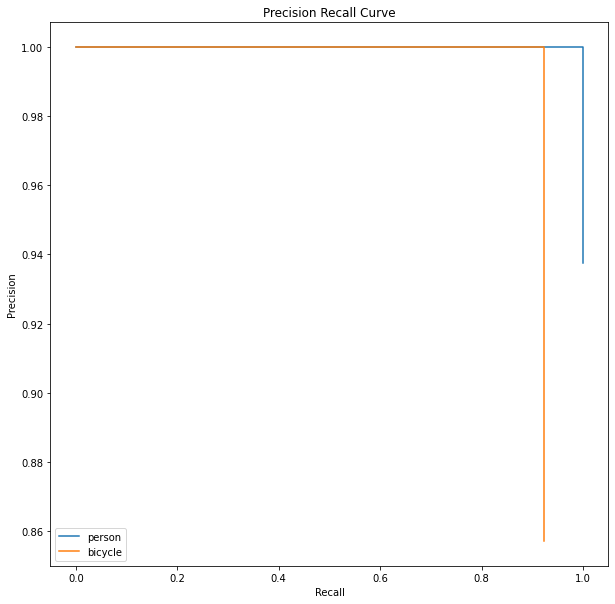

In [13]:
%matplotlib inline
ODM.calculate_mAP(iou_threshold=0.5)

## Visualize Ground Truth & Predictions

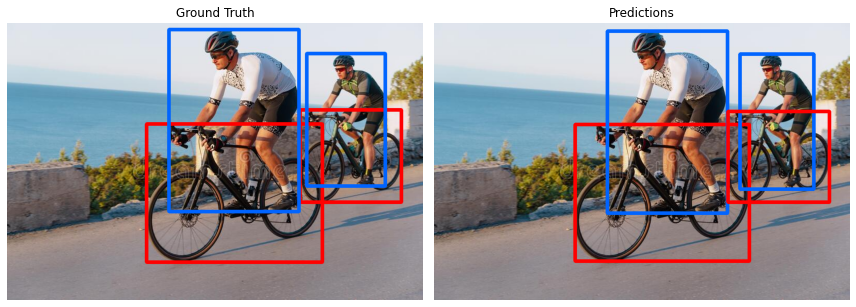

In [8]:
%matplotlib inline
ODM.visualize_pred_gt(image_indx=7)

##### References : https://leimao.github.io/blog/Object-Detection-Mean-Average-Precision-mAP/